# Forecasting best seller products

Find the top 20 best seller products and generate a model which forecasts the
sales these will have in the next year on a week-by-week basis.
The model should also be flexible to changing the product price and adjusting the
forecast based on this price.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
import statsmodels.api as sm
from pmdarima.arima import ADFTest

import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

from pandas.tseries.offsets import DateOffset

## Uploading datasets

In [2]:
#Uploading CSV

customers = pd.read_csv('datasets/customers_dataset.csv')
geolocation =pd.read_csv('datasets/geolocation_dataset.csv')
order_it = pd.read_csv('datasets/order_items_dataset.csv')
order_pay = pd.read_csv('datasets/order_payments_dataset.csv')
order_rev = pd.read_csv('datasets/order_reviews_dataset.csv')
orders = pd.read_csv('datasets/orders_dataset.csv')
product_cat = pd.read_csv('datasets/product_category_name_translation.csv')
products = pd.read_csv('datasets/products_dataset.csv')
sellers = pd.read_csv('datasets/sellers_dataset.csv')

# EDA

In [3]:
#información de la DDBB
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
#Inspección de valores faltantes
products.info()
products.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [5]:
order_it.isna().sum() #Verificación de valores faltantes

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## Merging Tables

In [6]:
#Merging tables
order=pd.merge(orders,order_it, on='order_id', how='outer')

order=pd.merge(order,order_pay, on='order_id', how='outer')

order=pd.merge(order,customers, on='customer_id', how='outer')

order=pd.merge(order,products, on='product_id', how='outer')

df=pd.merge(order,sellers, on='seller_id', how='outer')

df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20 00:00:00,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,40.0,516.0,2.0,750.0,30.0,28.0,28.0,13660.0,porto ferreira,SP
118430,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaN,NaN,2017-03-30 00:00:00,1.0,241a1ffc9cf969b27de6e72301020268,...,48.0,260.0,2.0,400.0,16.0,4.0,11.0,89031.0,blumenau,SC
118431,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16 00:00:00,1.0,1d187e8e7a30417fda31e85679d96f0f,...,43.0,729.0,2.0,2100.0,80.0,8.0,30.0,13478.0,americana,SP
118432,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08 00:00:00,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,19.0,531.0,1.0,5900.0,41.0,21.0,41.0,8320.0,sao paulo,SP


# Best Seller Products

In [7]:
#Agrupamiento y orden descendente según la cantidad de ventas del producto
df_bs=df.groupby(['product_id'])['product_id'].agg(['count']).sort_values('count', ascending=False).head(20)

In [8]:
#Cantidad de registros a filtrar de la base
df_bs['count'].sum()

6075

In [9]:
#Exportar 20 productos más vendidos
#df_bs.to_csv('best_seller.csv')

In [10]:
df_bs.reset_index(inplace=True)  #Reinicia los indices del dataframe agrupado

In [11]:
df_bs

,product_id,count
0,aca2eb7d00ea1a7b8ebd4e68314663af,536
1,99a4788cb24856965c36a24e339b6058,525
2,422879e10f46682990de24d770e7f83d,505
3,389d119b48cf3043d311335e499d9c6b,406
4,368c6c730842d78016ad823897a372db,395
5,53759a2ecddad2bb87a079a1f1519f73,389
6,d1c427060a0f73f6b889a5c7c61f2ac4,357
7,53b36df67ebb7c41585e8d54d6772e08,327
8,154e7e31ebfa092203795c972e5804a6,283
9,3dd2a17168ec895c781a9191c1e95ad7,278


# Forecasting model

In [12]:
#Filtrado de la base concatenada de acuerdo a los id de los productos que son best sellers
df_bsf=pd.merge(order,df_bs['product_id'],on='product_id',how='right')
df_bsf

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,25f4376934e13d3508486352e11a5db0,12fd2740039676063a874b9567dfa651,delivered,2018-05-17 16:59:11,2018-05-18 01:17:39,2018-05-18 13:02:00,2018-05-21 15:22:11,2018-05-25 00:00:00,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,...,sao jose dos campos,SP,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0
1,6d7de866a140b19d09e825b2a4e944c7,9e5ce657315b2bdb94033a494041ac25,delivered,2018-04-16 21:07:16,2018-04-16 22:10:15,2018-04-17 20:54:27,2018-04-24 20:38:55,2018-05-15 00:00:00,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,...,palhoca,SC,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0
2,6d7de866a140b19d09e825b2a4e944c7,9e5ce657315b2bdb94033a494041ac25,delivered,2018-04-16 21:07:16,2018-04-16 22:10:15,2018-04-17 20:54:27,2018-04-24 20:38:55,2018-05-15 00:00:00,2.0,aca2eb7d00ea1a7b8ebd4e68314663af,...,palhoca,SC,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0
3,a0d5b8474423ddf55228373b81a46272,3f7d26944f7f68bd2ac23b5e8b500ab0,delivered,2018-01-11 16:51:17,2018-01-12 02:38:34,2018-01-15 17:24:13,2018-01-22 21:18:33,2018-02-07 00:00:00,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,...,campo grande,MS,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0
4,f29d0fd6d4e6d5ce550e0b2f9335116c,55216cd56c9eaadec16f03d5aaf11d86,delivered,2018-05-17 16:34:49,2018-05-19 02:59:02,2018-05-21 13:45:00,2018-06-09 00:14:23,2018-06-13 00:00:00,1.0,aca2eb7d00ea1a7b8ebd4e68314663af,...,campos borges,RS,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,bfb51c4a799c319062db833fa3c5a157,f53404d33614c226871819898acb5ee5,delivered,2017-09-25 22:41:59,2017-09-25 22:56:16,2017-10-04 08:56:36,2017-10-11 19:06:24,2017-10-30 00:00:00,2.0,b532349fe46b38fbc7bb3914c1bdae07,...,dom feliciano,RS,moveis_decoracao,49.0,829.0,1.0,850.0,20.0,25.0,20.0
6071,bfb51c4a799c319062db833fa3c5a157,f53404d33614c226871819898acb5ee5,delivered,2017-09-25 22:41:59,2017-09-25 22:56:16,2017-10-04 08:56:36,2017-10-11 19:06:24,2017-10-30 00:00:00,3.0,b532349fe46b38fbc7bb3914c1bdae07,...,dom feliciano,RS,moveis_decoracao,49.0,829.0,1.0,850.0,20.0,25.0,20.0
6072,b149455fa7496682b0416179a74cb8bb,fdd462d38129a881c0620cebff8d5484,delivered,2017-11-08 14:42:39,2017-11-08 14:50:50,2017-11-10 16:12:57,2017-11-21 22:19:00,2017-11-29 00:00:00,1.0,b532349fe46b38fbc7bb3914c1bdae07,...,jau,SP,moveis_decoracao,49.0,829.0,1.0,850.0,20.0,25.0,20.0
6073,0a6f6183affc58729c775e30654be436,2bb87da72f42e1d9ece846a158974854,delivered,2018-04-11 17:41:30,2018-04-13 02:31:50,2018-04-14 01:41:47,2018-04-16 14:50:46,2018-04-27 00:00:00,1.0,b532349fe46b38fbc7bb3914c1bdae07,...,guarulhos,SP,moveis_decoracao,49.0,829.0,1.0,850.0,20.0,25.0,20.0


In [13]:
#Sort the columns
df_bsf=df_bsf.reindex(columns=['order_id','order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','order_item_id','customer_id','customer_unique_id','customer_zip_code_prefix','customer_city','customer_state','product_id','product_category_name','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm','shipping_limit_date','price','freight_value','payment_sequential','payment_type','payment_installments','payment_value','seller_id','seller_zip_code_prefix','seller_city','seller_state'])
df_bsf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 0 to 6074
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       6075 non-null   object 
 1   order_status                   6075 non-null   object 
 2   order_purchase_timestamp       6075 non-null   object 
 3   order_approved_at              6075 non-null   object 
 4   order_delivered_carrier_date   6069 non-null   object 
 5   order_delivered_customer_date  5990 non-null   object 
 6   order_estimated_delivery_date  6075 non-null   object 
 7   order_item_id                  6075 non-null   float64
 8   customer_id                    6075 non-null   object 
 9   customer_unique_id             6075 non-null   object 
 10  customer_zip_code_prefix       6075 non-null   int64  
 11  customer_city                  6075 non-null   object 
 12  customer_state                 6075 non-null   o

In [14]:
#Conversión del formato fecha

df_bsf['order_purchase_timestamp']=pd.to_datetime(df_bsf['order_purchase_timestamp'], format='%Y/%m/%d')
df_bsf

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,customer_id,customer_unique_id,...,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,25f4376934e13d3508486352e11a5db0,delivered,2018-05-17 16:59:11,2018-05-18 01:17:39,2018-05-18 13:02:00,2018-05-21 15:22:11,2018-05-25 00:00:00,1.0,12fd2740039676063a874b9567dfa651,372e0fc66eacb8698e4f9997d366d961,...,69.9,12.43,1.0,credit_card,5.0,82.33,955fee9216a65b617aa5c0531780ce60,NaN,NaN,NaN
1,6d7de866a140b19d09e825b2a4e944c7,delivered,2018-04-16 21:07:16,2018-04-16 22:10:15,2018-04-17 20:54:27,2018-04-24 20:38:55,2018-05-15 00:00:00,1.0,9e5ce657315b2bdb94033a494041ac25,51cbfa44126505de7a55fb99ba49648b,...,69.9,0.00,1.0,credit_card,1.0,139.80,955fee9216a65b617aa5c0531780ce60,NaN,NaN,NaN
2,6d7de866a140b19d09e825b2a4e944c7,delivered,2018-04-16 21:07:16,2018-04-16 22:10:15,2018-04-17 20:54:27,2018-04-24 20:38:55,2018-05-15 00:00:00,2.0,9e5ce657315b2bdb94033a494041ac25,51cbfa44126505de7a55fb99ba49648b,...,69.9,0.00,1.0,credit_card,1.0,139.80,955fee9216a65b617aa5c0531780ce60,NaN,NaN,NaN
3,a0d5b8474423ddf55228373b81a46272,delivered,2018-01-11 16:51:17,2018-01-12 02:38:34,2018-01-15 17:24:13,2018-01-22 21:18:33,2018-02-07 00:00:00,1.0,3f7d26944f7f68bd2ac23b5e8b500ab0,c8d183727fc9b4dcac256fbe246d6270,...,69.9,19.98,1.0,boleto,1.0,89.88,955fee9216a65b617aa5c0531780ce60,NaN,NaN,NaN
4,f29d0fd6d4e6d5ce550e0b2f9335116c,delivered,2018-05-17 16:34:49,2018-05-19 02:59:02,2018-05-21 13:45:00,2018-06-09 00:14:23,2018-06-13 00:00:00,1.0,55216cd56c9eaadec16f03d5aaf11d86,c1dc1162de49817a25314db3030276f5,...,69.9,0.00,1.0,boleto,1.0,69.90,955fee9216a65b617aa5c0531780ce60,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,bfb51c4a799c319062db833fa3c5a157,delivered,2017-09-25 22:41:59,2017-09-25 22:56:16,2017-10-04 08:56:36,2017-10-11 19:06:24,2017-10-30 00:00:00,2.0,f53404d33614c226871819898acb5ee5,5ab9552cd6c3162201301a5bf90e5466,...,38.4,16.11,1.0,credit_card,5.0,163.53,1025f0e2d44d7041d6cf58b6550e0bfa,NaN,NaN,NaN
6071,bfb51c4a799c319062db833fa3c5a157,delivered,2017-09-25 22:41:59,2017-09-25 22:56:16,2017-10-04 08:56:36,2017-10-11 19:06:24,2017-10-30 00:00:00,3.0,f53404d33614c226871819898acb5ee5,5ab9552cd6c3162201301a5bf90e5466,...,38.4,16.11,1.0,credit_card,5.0,163.53,1025f0e2d44d7041d6cf58b6550e0bfa,NaN,NaN,NaN
6072,b149455fa7496682b0416179a74cb8bb,delivered,2017-11-08 14:42:39,2017-11-08 14:50:50,2017-11-10 16:12:57,2017-11-21 22:19:00,2017-11-29 00:00:00,1.0,fdd462d38129a881c0620cebff8d5484,1743631071053f26bb95b0ca2ca4c5f6,...,38.4,12.69,1.0,credit_card,1.0,51.09,1025f0e2d44d7041d6cf58b6550e0bfa,NaN,NaN,NaN
6073,0a6f6183affc58729c775e30654be436,delivered,2018-04-11 17:41:30,2018-04-13 02:31:50,2018-04-14 01:41:47,2018-04-16 14:50:46,2018-04-27 00:00:00,1.0,2bb87da72f42e1d9ece846a158974854,8a493d14ab08c6d60673881fc9525c6d,...,35.0,8.88,1.0,boleto,1.0,43.88,1025f0e2d44d7041d6cf58b6550e0bfa,NaN,NaN,NaN


In [15]:
df_bsf=df_bsf.set_index('order_purchase_timestamp')

In [16]:
df_bsf=df_bsf.sort_values('order_purchase_timestamp')

In [17]:
df_bsf

,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,customer_id,customer_unique_id,customer_zip_code_prefix,...,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,seller_id,seller_zip_code_prefix,seller_city,seller_state
order_purchase_timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-31 17:15:33,6e68d4f670783e41ced4e82d14debce9,delivered,2017-02-02 17:10:21,2017-02-06 09:38:07,2017-02-10 14:53:49,2017-03-03 00:00:00,1.0,6d4771e7b12516d2f6b98a6efcd88fc7,0b4f18a0cf7872514b14ebf56c56e68f,13802,...,64.99,11.06,1.0,credit_card,3.0,76.05,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
2017-02-03 22:32:04,37420f333a6877b6e54ea0a728af2542,delivered,2017-02-07 04:10:24,2017-02-08 07:04:40,2017-02-13 08:12:15,2017-03-03 00:00:00,1.0,4e5fd9f9e9b1d0f13e385284cfd57882,cb7f3ea593a9da0369cc5f48232a4e21,9080,...,19.99,10.96,1.0,boleto,1.0,30.95,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
2017-02-05 17:55:05,ad0d46c22c5a9dd2699f5142b1882f5f,delivered,2017-02-05 18:05:20,2017-02-09 16:29:43,2017-02-10 06:44:41,2017-03-06 00:00:00,2.0,37be731e9a59816c2139b344f51147dc,f4ff1a79dac99d99375405621276c176,6900,...,19.99,3.14,1.0,credit_card,4.0,96.93,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
2017-02-05 19:47:13,591634e3db632b8d5a60099a1b81cf7a,delivered,2017-02-05 20:02:29,2017-02-07 10:05:49,2017-02-13 11:53:50,2017-03-08 00:00:00,1.0,1328b35044ea458d162dc73bc6d4c02f,35a23d4b2b877b2565e30339e0c0c45b,83501,...,19.99,14.52,1.0,credit_card,3.0,34.51,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
2017-02-06 09:29:52,e95949c45d8dc1a2537b40b90346108e,delivered,2017-02-06 09:42:04,2017-02-07 10:05:50,2017-02-09 08:14:13,2017-03-06 00:00:00,1.0,97483c726a6efd0437639b0c0c4444ad,edeacde884816ac5fb6b44e34d3d6bb4,5623,...,19.99,10.96,1.0,credit_card,1.0,30.95,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-25 15:44:41,b4580174bbfb1dacc6e2cd89251d842a,delivered,2018-08-25 15:55:21,2018-08-27 15:02:00,2018-08-30 14:32:44,2018-09-13 00:00:00,1.0,25fcf13e3c9b675d599bc5c4ffbc8398,e9610db1ce903b47ea5afa0927762873,93310,...,89.90,5.82,1.0,credit_card,9.0,95.72,cc419e0650a3c5ba77189a1882b7556a,NaN,NaN,NaN
2018-08-25 17:01:09,cf6452b3b5328de1ec580502fd48fcd7,delivered,2018-08-25 17:15:20,2018-08-27 14:24:00,2018-08-28 20:15:49,2018-09-19 00:00:00,1.0,5928ea9c80d9614d8a17a6e4f13de9ee,773427e58e9396f234a16271a8fa4947,29060,...,330.00,7.54,1.0,credit_card,7.0,413.58,f7ba60f8c3f99e7ee4042fdef03b70c4,NaN,NaN,NaN
2018-08-25 20:10:27,73cfaa863221d5987b3f6aa644affca3,delivered,2018-08-28 03:45:18,2018-08-28 16:05:00,2018-08-30 21:32:33,2018-09-06 00:00:00,1.0,f06bb0bb030eef32d9ce6d9a4f177605,71cf80748ed347ba6a5fd7e0a0828eea,12239,...,49.90,20.99,1.0,boleto,1.0,70.89,1f50f920176fa81dab994f9023523100,NaN,NaN,NaN


In [18]:
df_bsf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6075 entries, 2017-01-31 17:15:33 to 2018-08-27 16:12:22
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       6075 non-null   object 
 1   order_status                   6075 non-null   object 
 2   order_approved_at              6075 non-null   object 
 3   order_delivered_carrier_date   6069 non-null   object 
 4   order_delivered_customer_date  5990 non-null   object 
 5   order_estimated_delivery_date  6075 non-null   object 
 6   order_item_id                  6075 non-null   float64
 7   customer_id                    6075 non-null   object 
 8   customer_unique_id             6075 non-null   object 
 9   customer_zip_code_prefix       6075 non-null   int64  
 10  customer_city                  6075 non-null   object 
 11  customer_state                 6075 non-null   object 
 12  product_id  

### Grouping in a weekly basis

In [19]:
#Agrupación semanal y suma de ventas de los best seller
y=df_bsf.price.resample('W').sum()

In [20]:
y.isna().sum()

0

In [21]:
y=y.to_frame()

In [22]:
y

,price
order_purchase_timestamp,
2017-02-05,124.96
2017-02-12,164.94
2017-02-19,224.98
2017-02-26,534.94
2017-03-05,1133.85
...,...
2018-08-05,3157.29
2018-08-12,8243.99
2018-08-19,4383.86


## Sales behaviour

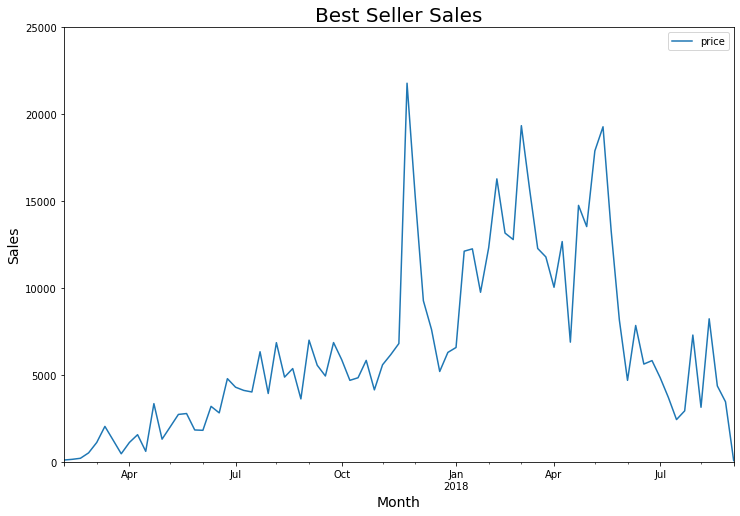

In [23]:
#Revisión del comportamiento de las ventas semanales de los best sellers
rcParams['figure.figsize']=15,7

y.plot(figsize=(12,8))
plt.ylim([0, 25000])
plt.title('Best Seller Sales',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()
#y.plot()


In [24]:
#Validación del índice temporal, si hay huecos.
(y.index == pd.date_range(start=y.index.min(),
                              end=y.index.max(),
                              freq=y.index.freq)).all()

True

## Testing stationarity

In [25]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['Test estadístico ADF','p-value','#Lags usados','Número de observaciones usadas']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Evidencia fuerte contra la hipotesis nula(Ho), se rechaza la hipotesis nula. Los datos no tienen raíz unitaria y son estacionarios")
    else:
        print("Evidencia débil contra la hipotesis nula, la serie de tiempo tiene una raíz unitaria, lo que indica que no es estacionaria ")
    

In [26]:
adfuller_test(y)

Test estadístico ADF : -2.99874981965811
p-value : 0.03501131644745605
#Lags usados : 0
Número de observaciones usadas : 82
Evidencia fuerte contra la hipotesis nula(Ho), se rechaza la hipotesis nula. Los datos no tienen raíz unitaria y son estacionarios


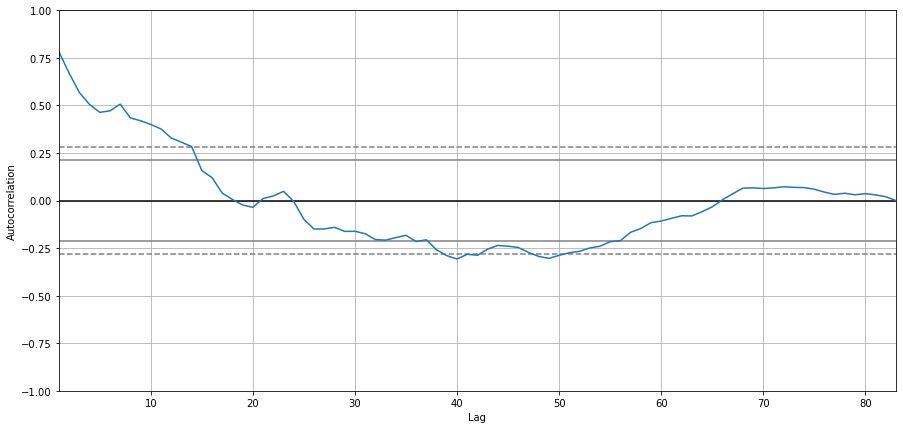

In [27]:
autocorrelation_plot(y['price'])
plt.show()

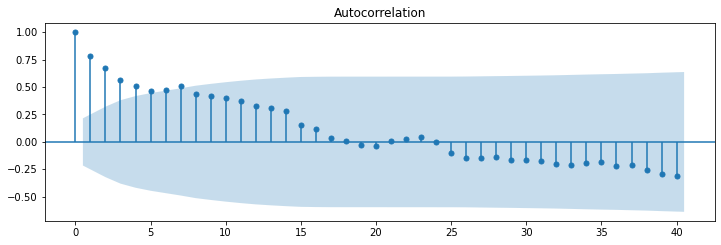

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y['price'].dropna(),lags=40,ax=ax1)


In [29]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq=[(x[0], x[1], x[2], 52) for x in pdq]
print('examples of parameter combinations for seasonal ARIMA....')
print('SARIMAX:{} x {}'.format(pdq[1],seasonal_pdq[1]))
print('SARIMAX:{} x {}'.format(pdq[1],seasonal_pdq[2]))
print('SARIMAX:{} x {}'.format(pdq[2],seasonal_pdq[3]))
print('SARIMAX:{} x {}'.format(pdq[2],seasonal_pdq[4]))

examples of parameter combinations for seasonal ARIMA....
SARIMAX:(0, 0, 1) x (0, 0, 1, 52)
SARIMAX:(0, 0, 1) x (0, 1, 0, 52)
SARIMAX:(0, 1, 0) x (0, 1, 1, 52)
SARIMAX:(0, 1, 0) x (1, 0, 0, 52)


In [30]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        #try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results=mod.fit()
            print('ARIMA{}x{} 52 - AIC:{}'.format(param,param_seasonal,results.aic))
        #except:
         #   continue

ARIMA(0, 0, 0)x(0, 0, 0, 52) 52 - AIC:1716.0761003703624
ARIMA(0, 0, 0)x(0, 0, 1, 52) 52 - AIC:636.5424274732003
ARIMA(0, 0, 0)x(0, 1, 0, 52) 52 - AIC:636.6072852563807
ARIMA(0, 0, 0)x(0, 1, 1, 52) 52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52) 52 - AIC:658.3681338937592
ARIMA(0, 0, 0)x(1, 0, 1, 52) 52 - AIC:638.5424274766286
ARIMA(0, 0, 0)x(1, 1, 0, 52) 52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 52) 52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52) 52 - AIC:1649.267277067665
ARIMA(0, 0, 1)x(0, 0, 1, 52) 52 - AIC:599.8090773675694
ARIMA(0, 0, 1)x(0, 1, 0, 52) 52 - AIC:598.9382683340928
ARIMA(0, 0, 1)x(0, 1, 1, 52) 52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 52) 52 - AIC:642.1466042966565
ARIMA(0, 0, 1)x(1, 0, 1, 52) 52 - AIC:601.7345323575037
ARIMA(0, 0, 1)x(1, 1, 0, 52) 52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 52) 52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52) 52 - AIC:1540.0573500769242
ARIMA(0, 1, 0)x(0, 0, 1, 52) 52 - AIC:562.1276900727562
ARIMA(0, 1, 0)x(0, 1, 0, 52) 52 - AIC:563.8808460799002
ARIMA(0, 1, 0)x(0,

In [31]:
model=ARIMA(y['price'],order=(1, 1, 1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -773.063
Method:                       css-mle   S.D. of innovations           3001.228
Date:                Tue, 21 Dec 2021   AIC                           1554.125
Time:                        11:48:09   BIC                           1563.752
Sample:                    02-12-2017   HQIC                          1557.990
                         - 09-02-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            33.9573    134.794      0.252      0.801    -230.233     298.148
ar.L1.D.price     0.4718      0.159      2.962      0.003       0.160       0.784
ma.L1.D.price    -0.7938      0.104     -7.654      0.000      -0.997      -0.591
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1196           +0.0000j            2.1196            0.0000
MA.1            1.2597           +0.0000j            1.2597            0.0000
-----------------------------------------------------------------------------
"""

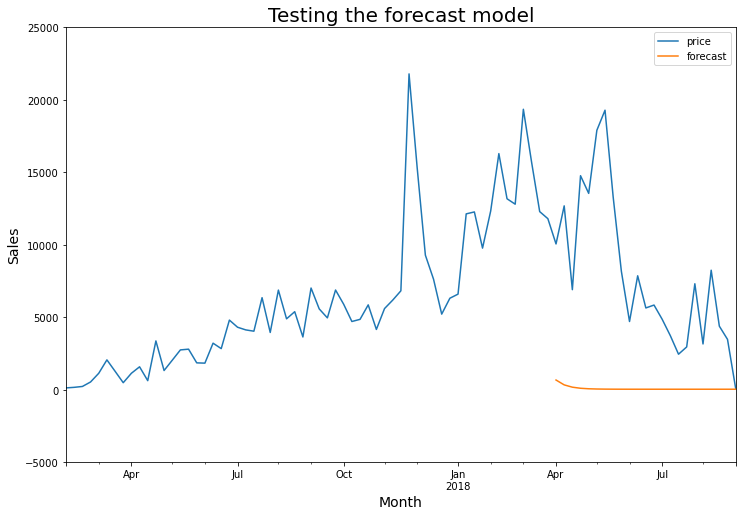

In [32]:
y['forecast']=model_fit.predict(start=60,end=82,dynamic=True)
y[['price','forecast']].plot(figsize=(12,8))
plt.ylim([-5000, 25000])
plt.title('Testing the forecast model',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

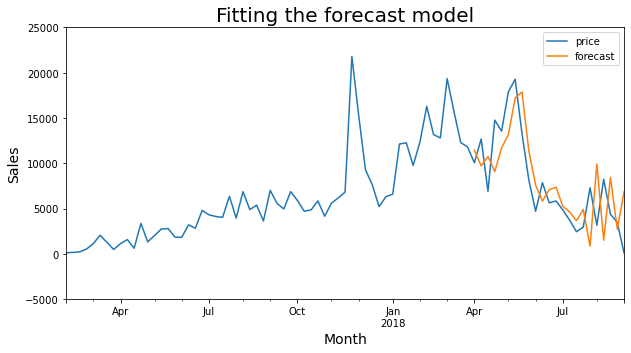

In [33]:
model=sm.tsa.statespace.SARIMAX(y['price'],order=(1, 0, 0),seasonal_order=(0, 1, 0, 52))
results=model.fit()
y['forecast']=results.predict(start=60,end=82,dynamic=False)
y[['price','forecast']].plot(figsize=(10,5))
plt.ylim([-5000, 25000])
plt.title('Fitting the forecast model',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

In [34]:
y['forecast']=y['forecast'].to_frame()
df_p_f=y[['price','forecast']].tail(23)
df_p_f.sample(10)

,price,forecast
order_purchase_timestamp,,
2018-08-26,3473.46,2727.977327
2018-07-29,7309.24,853.496421
2018-04-15,6901.53,10743.402844
2018-05-27,8178.29,11412.410446
2018-07-01,4858.24,5256.529169
2018-06-24,5840.46,7359.450139
2018-04-22,14763.67,9088.031573
2018-08-19,4383.86,8439.772694
2018-04-01,10056.05,11447.801770


In [35]:
r2_score(df_p_f['price'],df_p_f['forecast'])

0.4192171076342951

In [36]:
future_dates=[y.index[-1]+ DateOffset(weeks=x)for x in range(0,82)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=y.columns)

In [37]:
future_df=pd.concat([y,future_datest_df])
future_df.describe()

,price,forecast
count,83.000000,23.000000
mean,6620.414337,8217.344006
std,5072.927862,4453.734072
min,89.900000,853.496421
25%,3054.520000,5079.650281
50%,5383.340000,7598.441193
75%,8763.675000,11077.906645
max,21787.170000,17868.750753


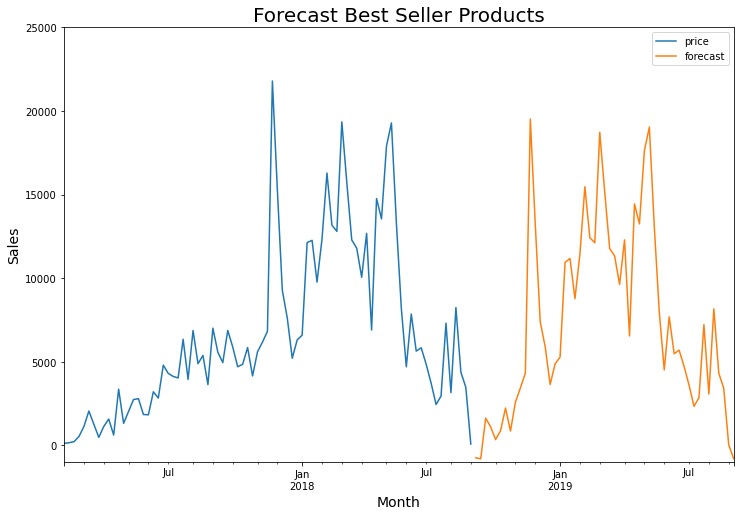

In [38]:
future_df['forecast'] = results.predict(start=83,end=83+52,dynamic=True)
future_df[['price', 'forecast']].plot(figsize=(12, 8))
plt.xlim(['2017-02-05', '2019-09-02'])
plt.ylim([-1000, 25000])
plt.title('Forecast Best Seller Products',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

In [39]:
#future_df.to_excel('forecast.xlsx')

As we can see in the graph above, the model has done a forecast based in sales of best seller between January 2017 until september 2018 in a weekly basis. Howewer, in forecasted values, there are some negative values, because of optimization of model. 

The ARIMA (Autoregressive integrated moving average) model uses 3 parameters: p, d and q.

p in the number of autoregressive terms, d is the number of non-seasonal differences needed for stationarity and q is the number of lagged forecaste errors in the prediction equation.

With AD Fuller test, it was possible that the data has a stational behavior. Then, the d value was set as 0.

In order to use right model parameters, I used the AIC (Akaike information criterion) as a estimator of prediction error and relative quality of the chosen model. The selected parameters was (1,0,0) and parameters for seasonal order was (0,1,0,52). This parameters was selected taking in count that d must be 0 and least AIC.

The model optimization is an activity that I will improve in order to learn more about forecasting models.

# Price updating and new forecasting

Here, you find the product_id and price average of best seller products which you want to update price

In [40]:
df_bsf.groupby(['product_id'])['price'].mean(['price'])

product_id
154e7e31ebfa092203795c972e5804a6     22.520035
2b4609f8948be18874494203496bc318     87.282556
35afc973633aaeb6b877ff57b2793310     87.811176
368c6c730842d78016ad823897a372db     54.246582
389d119b48cf3043d311335e499d9c6b     54.633473
3dd2a17168ec895c781a9191c1e95ad7    149.935971
422879e10f46682990de24d770e7f83d     54.841228
42a2c92a0979a949ca4ea89ec5c7b934     59.394054
53759a2ecddad2bb87a079a1f1519f73     54.711825
53b36df67ebb7c41585e8d54d6772e08    116.691774
5a848e4ab52fd5445cdc07aab1c40e48    122.990000
7c1bd920dbdf22470b68bde975dd3ccf     60.028462
99a4788cb24856965c36a24e339b6058     88.207543
a62e25e09e05e6faf31d90c6ec1aa3d1    106.407895
aca2eb7d00ea1a7b8ebd4e68314663af     71.358582
b532349fe46b38fbc7bb3914c1bdae07     36.523944
bb50f2e236e5eea0100680137654686c    327.679426
d1c427060a0f73f6b889a5c7c61f2ac4    137.650980
e0d64dcfaa3b6db5c54ca298ae101d05    164.185721
e53e557d5a159f5aa2c5e995dfdf244b     84.346845
Name: price, dtype: float64

If you want to adjunt the price of some product, please run the next cell:

In [41]:
product_ch=input('Enter producto_id: ')

Enter producto_id: 1


In [42]:
new_price=float(input('Enter new price: '))

Enter new price: 10


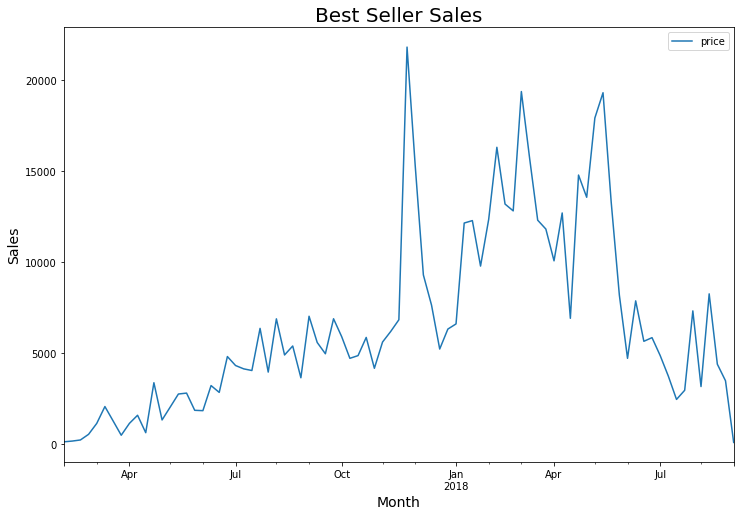

In [43]:
new_df=df_bsf.copy()
new_df.loc[new_df['product_id'] == product_ch,'price']= new_price
y=new_df.price.resample('W').sum()
y=y.to_frame()
rcParams['figure.figsize']=15,7

y.plot(figsize=(12,8))
#plt.ylim([0, 25000])
plt.title('Best Seller Sales',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

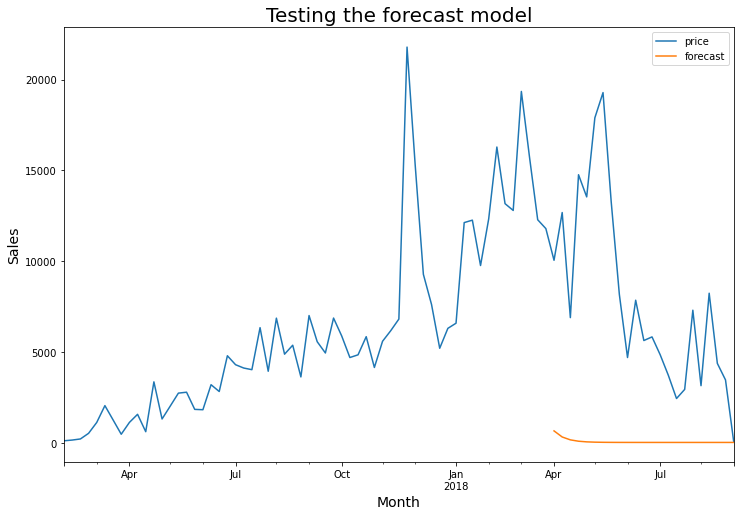

In [44]:
model=ARIMA(y['price'],order=(1, 1, 1))
model_fit=model.fit()
model_fit.summary()

y['forecast']=model_fit.predict(start=60,end=82,dynamic=True)
y[['price','forecast']].plot(figsize=(12,8))
#plt.ylim([-5000, 25000])
plt.title('Testing the forecast model',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

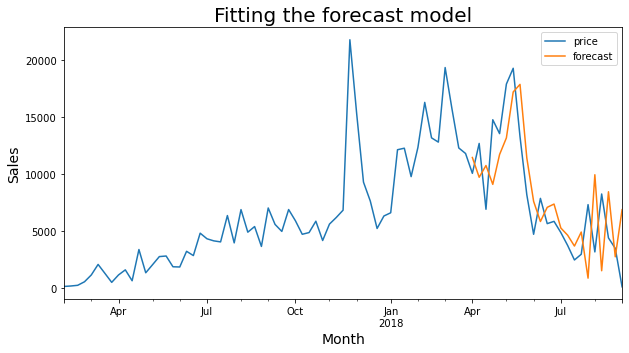

In [45]:
model=sm.tsa.statespace.SARIMAX(y['price'],order=(1, 0, 0),seasonal_order=(0, 1, 0, 52))
results=model.fit()
y['forecast']=results.predict(start=60,end=82,dynamic=False)
y[['price','forecast']].plot(figsize=(10,5))
#plt.ylim([-5000, 25000])
plt.title('Fitting the forecast model',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

In [46]:
future_dates=[y.index[-1]+ DateOffset(weeks=x)for x in range(0,82)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=y.columns)

future_df=pd.concat([y,future_datest_df])
future_df.describe()

,price,forecast
count,83.000000,23.000000
mean,6620.414337,8217.344006
std,5072.927862,4453.734072
min,89.900000,853.496421
25%,3054.520000,5079.650281
50%,5383.340000,7598.441193
75%,8763.675000,11077.906645
max,21787.170000,17868.750753


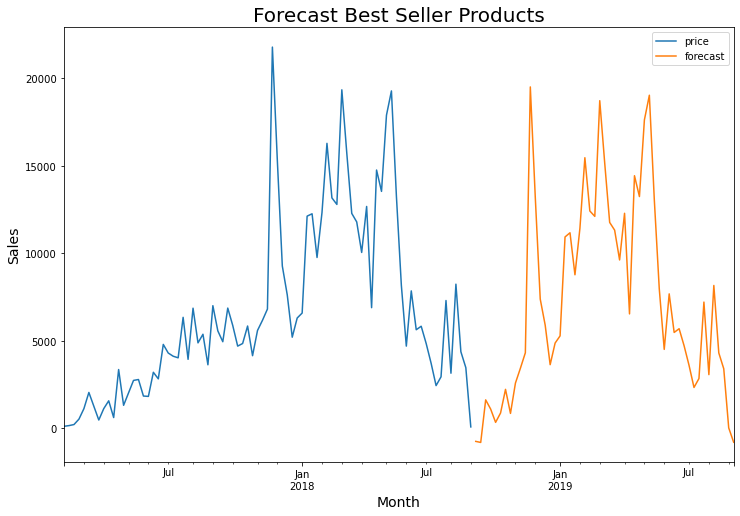

In [47]:
future_df['forecast'] = results.predict(start=83,end=83+52,dynamic=True)
future_df[['price', 'forecast']].plot(figsize=(12, 8))
plt.xlim(['2017-02-05', '2019-09-02'])
#plt.ylim([-1000, 25000])
plt.title('Forecast Best Seller Products',size=20)
plt.xlabel('Month',size=14)
plt.ylabel('Sales',size=14)

plt.show()

In [48]:
#new_df.to_excel('example.xlsx')

# Item 2

Considering that that the cost of each sold product is 70% of the actual price
determine what products compose the 80% of the profits for the last 2 years, with
this expose the most and least profitable categories for Valoreo. If you had a
certain budget ($100,000 USD) for marketing push, how do you distribute it among
the categories and why?

In [49]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20 00:00:00,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,40.0,516.0,2.0,750.0,30.0,28.0,28.0,13660.0,porto ferreira,SP
118430,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaN,NaN,2017-03-30 00:00:00,1.0,241a1ffc9cf969b27de6e72301020268,...,48.0,260.0,2.0,400.0,16.0,4.0,11.0,89031.0,blumenau,SC
118431,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16 00:00:00,1.0,1d187e8e7a30417fda31e85679d96f0f,...,43.0,729.0,2.0,2100.0,80.0,8.0,30.0,13478.0,americana,SP
118432,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08 00:00:00,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,19.0,531.0,1.0,5900.0,41.0,21.0,41.0,8320.0,sao paulo,SP


In [50]:
df['cost']=df['price']*0.7

In [51]:
df['utility']=df['price']*0.3

In [52]:
#df.info()

In [53]:
total_profits=df['utility'].sum()
print(total_profits)

4262775.093


# Pareto principle for profits

In [54]:
df_sum=df.groupby(['product_id','product_category_name'])['utility'].agg(['sum']).sort_values('sum',ascending= False )

df_sum['sum_cum']=df_sum.cumsum()
df_sum['cumulative_percentage']=df_sum['sum_cum'] / total_profits
df_sum.reset_index(inplace=True)
df_sum['absolute porcentage']=df_sum['sum']/total_profits*100

pareto=df_sum[df_sum['cumulative_percentage'] <=0.8]
#pareto.groupby(['product_category_name']).sum()

### Products in 80% of profits

In [55]:
df_sum

,product_id,product_category_name,sum,sum_cum,cumulative_percentage,absolute porcentage
0,bb50f2e236e5eea0100680137654686c,beleza_saude,20545.500,2.054550e+04,0.004820,0.481975
1,d6160fb7873f184099d9bc95e30376af,pcs,17084.649,3.763015e+04,0.008828,0.400787
2,6cdd53843498f92890544667809f1595,beleza_saude,16733.970,5.436412e+04,0.012753,0.392560
3,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,14742.420,6.910654e+04,0.016212,0.345841
4,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,13892.688,8.299923e+04,0.019471,0.325907
...,...,...,...,...,...,...
32336,5304ff3fa35856a156e1170a6022d34d,artes,1.050,4.205485e+06,0.986560,0.000025
32337,2e8316b31db34314f393806fd7b6e185,papelaria,0.897,4.205486e+06,0.986561,0.000021
32338,680cc8535be7cc69544238c1d6a83fe8,pet_shop,0.870,4.205487e+06,0.986561,0.000020
32339,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,0.765,4.205487e+06,0.986561,0.000018


In [56]:
pareto

,product_id,product_category_name,sum,sum_cum,cumulative_percentage,absolute porcentage
0,bb50f2e236e5eea0100680137654686c,beleza_saude,20545.500,20545.500,0.004820,0.481975
1,d6160fb7873f184099d9bc95e30376af,pcs,17084.649,37630.149,0.008828,0.400787
2,6cdd53843498f92890544667809f1595,beleza_saude,16733.970,54364.119,0.012753,0.392560
3,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,14742.420,69106.539,0.016212,0.345841
4,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,13892.688,82999.227,0.019471,0.325907
...,...,...,...,...,...,...
8786,962f5772bee158b6fa65e4112823c598,beleza_saude,93.000,3409765.443,0.799893,0.002182
8787,5856763b975347ea6ea65dc890897b0a,automotivo,93.000,3409858.443,0.799915,0.002182
8788,fca5350a69eb4d8ae4f5884413ebd0e5,perfumaria,93.000,3409951.443,0.799937,0.002182
8789,78c4f2e6da6786ab39f8806a75c3db33,relogios_presentes,93.000,3410044.443,0.799959,0.002182


In [57]:
category_profit=pareto.groupby(['product_category_name'])['sum'].agg(['sum']).sort_values('sum',ascending= False )
category_profit['category_absolute_porcentage']=category_profit['sum']/total_profits*100
category_profit

,sum,category_absolute_porcentage
product_category_name,,
relogios_presentes,344174.592,8.073956
beleza_saude,328946.430,7.716720
cama_mesa_banho,243988.971,5.723712
informatica_acessorios,243972.552,5.723327
esporte_lazer,234889.170,5.510241
...,...,...
cds_dvds_musicais,219.000,0.005137
fraldas_higiene,199.500,0.004680
artes_e_artesanato,192.435,0.004514


## Most profitable category

In [58]:
category_profit.head(1)

,sum,category_absolute_porcentage
product_category_name,,
relogios_presentes,344174.592,8.073956


## Least profitable category

In [59]:
category_profit.tail(1)

,sum,category_absolute_porcentage
product_category_name,,
casa_conforto_2,104.49,0.002451


With $ 100k USD you invest a percentage directly proportional to the profit percentage because I believe that with this investment model efforts can be concentrated in the categories that leave the greatest benefit to the business.

Also, this model could leave out some categories. However, we can reduce the portfolio of products with less benefit, optimizing the marketing and operation efforts. In conclusion, the net profit of the business increases.

# Item 3

Can you propose a way to group sellers to profile them? This groups can be
referenced or preferred for certain kind of customer?

In [60]:
#df.to_excel('df.xlsx')

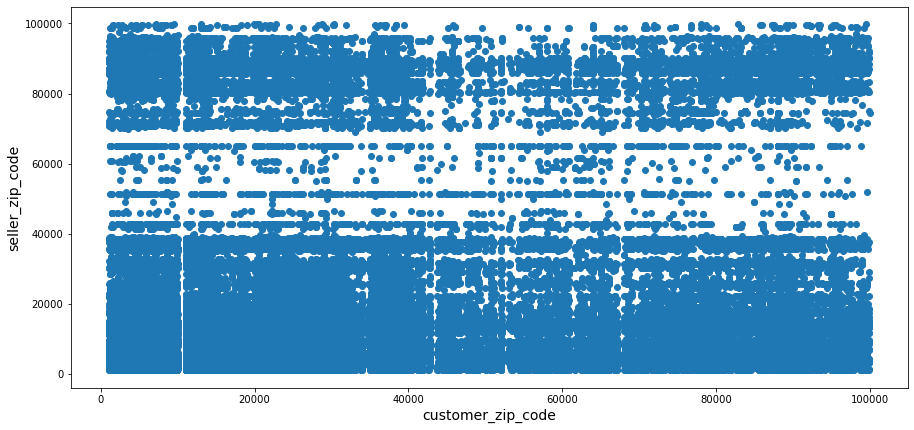

In [61]:
y = df['seller_zip_code_prefix'].values
x = df['customer_zip_code_prefix'].values
plt.ylabel('seller_zip_code',size=14)
plt.xlabel('customer_zip_code',size=14)
plt.scatter(x,y)

plt.show()

In the graph above, we can see that some sellers have sold to almost every customer locations. But, some others have records in few customer locations. We might consider grouping sellers based on the locations of customers who frequently ship products.

Also we could see that there are no a correlation between customer and seller location. So, there is not a parameter that could afect sales.

In [62]:
#pip freeze